# Alzheimer's Brain Shape Analysis in Kendall’s Shape Space


This notebook analyzes geometric differences in the corpus callosum between Control and Alzheimer's subjects using Kendall’s shape space. These results correspond directly to those discussed in the accompanying research-style paper (paper.pdf), which provides full mathematical background and detailed interpretations.

Main steps in this notebook:
1. Load and preprocess 2D brain shape landmark data.
2. Compute Fréchet mean shapes for each group.
3. Quantify shape differences using Kendall shape distance.
4. Run permutation tests using energy distance.
5. Perform hierarchical clustering and visualize structure using dendrorams.

All methods aside from clustering are implemented from scratch in Python.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.spatial import procrustes
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform

## Data
We load:
- Control vs Alzheimer's brain shapes (ADNI dataset)
- Simulated toy shapes (hand / hammer / glass) for validation

In [ ]:
NCLdataM= pd.read_csv('NCLdataM.csv', header=None)
NCLdataF = pd.read_csv('NCLdataF.csv', header=None)

ADLdataM = pd.read_csv('ADLdataM.csv', header=None)
ADLdataF = pd.read_csv('ADLdataF.csv', header=None)

control_M = create_shape_list(NCLdataM)
control_F = create_shape_list(NCLdataF)
alzheimers_M = create_shape_list(ADLdataM)
alzheimers_F = create_shape_list(ADLdataF)


In [ ]:
print("Number of Alzheimer Male shapes:", len(alzheimers_M))
print("Number of Alzheimer Female shapes:", len(alzheimers_F))
print("Number of Control Male shapes:", len(control_M))
print("Number of Control Female shapes:", len(control_F))

Number of Alzheimer Male shapes: 98
Number of Alzheimer Female shapes: 88
Number of Control Male shapes: 116
Number of Control Female shapes: 107


In [ ]:
#simulation data

data = np.load("registered_shapes.npz", allow_pickle=True)

hand = data["k_hand"].tolist()
glass = data["k_glass"].tolist()
hammer = data["k_hammer"].tolist()

glass = [np.array(item).T for item in glass]
hammer = [np.array(item).T for item in hammer]
hand = [np.array(item).T for item in hand]

## Functions

These functions implement core geometry on Kendall’s shape space:
- Centering and scaling shapes
- Optimal rotation alignment
- Fréchet mean computation
- Kendall distance matrix
- Permutation test for distributional differences

In [ ]:
#helper functions, run this first

def plot_shape(X, label = None, alpha = 1, col = None):
  plt.plot(X[:, 0], X[:, 1], marker='o', linestyle='-', label = label, alpha = alpha, color = col)

def create_shape_list(df):
    shapes = []
    for i in range(df.shape[1] // 2):
        X = df.iloc[:, 2 * i].values
        Y = df.iloc[:, 2 * i + 1].values
        shape = np.stack([X, Y], axis=1)  #shape: (50, 2)
        shapes.append(shape)
    return shapes



In [ ]:
def euclidean_distance(X1, X2):
  """
  Returns the standard Euclidean (Frobenius) distance between two shapes X1 and X2.
  """
  return np.linalg.norm(np.array(X1) - np.array(X2))


def scale_distance(X1, X2):
  """
  Computes the Kendall shape distance between two centered,
  scaled shapes X1 and X2 after optimal rotation alignment.
  Returns the geodesic angle theta.
  """

  if np.allclose(X1, X2):
        return 0

  O = optimal_O(X2, X1)
  X2_rotated = X2 @ O
  theta = np.arccos(np.clip(np.trace(X1.T @ X2_rotated), -1.0, 1.0))

  return theta


def scale_exp_map(X, v):
   """
  Exponential map on the shape sphere:
  move from base shape X along tangent direction v.
  Returns a new shape reached by stepping along the geodesic defined by v.
  """
  norm_v = np.linalg.norm(v, 'fro')
  if np.isclose(norm_v, 0.0):
        return X
  return np.cos(norm_v) * X + np.sin(norm_v) * (v / norm_v)


def scale_log_map(X1, X2):
  """
  Logarithm map on the shape sphere:
  project X2 back to the tangent space at X1.
  Returns the tangent vector v at X1 pointing toward X2.
  """
  theta = scale_distance(X1, X2)
  X2_rotated = X1 @ optimal_O(X1, X2)
  if np.isclose(theta, 0.0):
        return np.zeros_like(X1)
  return (theta / np.sin(theta)) * (X2_rotated - X1 * np.cos(theta))


def center_shape(X):
  """
  Removes translation by centering a shape X so that its centroid is at the origin.
  """
  k = X.shape[0]
  ones_k = np.ones((k, 1))
  v = (X.T @ ones_k) / k
  X_centered = X - (v @ ones_k.T).T
  return X_centered


def scale_shape(X):
  """
  Removes scale by normalizing a centered shape X to unit Frobenius norm.
  """
  X_scaled = X / np.sqrt(np.trace(X.T @ X))

  return X_scaled


def optimal_O(X1, X2):
  """
  Computes the optimal rotation matrix O aligning X2 to X1
  using orthogonal Procrustes.
  """
  U, _, Vt = np.linalg.svd(X1.T @ X2)
  O = U @ Vt
  return O


def frechet_mean(shapes, max_iter = 1000, eps=1e-6, seed = 66554):
  """
  Estimates the Fréchet mean shape (intrinsic average) of a list of shapes
  in Kendall's shape space using iterative updates on the manifold.

  Stops when the update direction has small Frobenius norm (< eps) or max_iter is reached.
  """
  np.random.seed(seed)

  shapes_normalized = [scale_shape(center_shape(X)) for X in shapes]
  mu = shapes_normalized[np.random.randint(len(shapes_normalized))]

  for i in range(max_iter):

    V_i = sum([scale_log_map(mu, X) for X in shapes_normalized]) / len(shapes_normalized)
    mu_next = scale_exp_map(mu, 0.5*V_i)

    if np.linalg.norm(V_i, 'fro') < eps:
      print("converged after " + str(i) + " iterations")
      break

    mu = mu_next
  return mu


def D_euclidean_distance(X_shapes, Y_shapes):
  """
  Builds a full pairwise Euclidean distance matrix D for two shape groups.
  Returns:
      D : (n+m) x (n+m) matrix of Euclidean distances
      n : size of first group
      m : size of second group
  """
  n = len(X_shapes)
  m = len(Y_shapes)
  Z = X_shapes + Y_shapes
  D = np.zeros((n+m, n+m))

  for i in range(n+m):
    for j in range(n+m):
      D[i, j] = euclidean_distance(Z[i], Z[j])
  return D, n, m


def D_kendall_distance(X_shapes, Y_shapes):
  """
  Builds a full pairwise Kendall shape distance matrix D for two shape groups.
  Shapes are first centered and scaled. Distances are symmetric and diagonal is 0.

  Returns:
      D : (n+m) x (n+m) matrix of Kendall shape space distances
      n : size of first group
      m : size of second group
  """
  n = len(X_shapes)
  m = len(Y_shapes)
  Z = X_shapes + Y_shapes
  D = np.zeros((n+m, n+m))

  for i in range(n+m):
    for j in range(n+m):
      Z_i = scale_shape(center_shape(Z[i]))
      Z_j = scale_shape(center_shape(Z[j]))
      d = scale_distance(Z_i, Z_j)
      D[i, j] = D[j, i] = d

  np.fill_diagonal(D, 0)

  return D, n, m


def compute_energy(D, n, m):
  """
  Computes the two-sample energy statistic from a pairwise distance matrix D of two shape groups
  comparing group X (size n) and group Y (size m).

  Higher values indicate more separation between the two distributions.
  """
  D_xx = D[:n, :n]
  D_yy = D[n:, n:]
  D_xy = D[:n, n:]

  return (2 / (n * m)) * np.sum(D_xy) - (1 / (n**2)) * np.sum(D_xx) - (1 / (m**2)) * np.sum(D_yy)


def permutation_test(D, n, m, num_iter=10000):
  """
  Runs a permutation test on the energy statistic of a pairwise distance matrix D of two shape groups:
  shuffle group labels, recompute the statistic, and estimate a p-value.

  Returns:
      p_value : Fraction of permutations with greater statistic than the observed one.
  """
  D_ts_true = compute_energy(D, n, m)
  counter = 0

  for i in range(num_iter):
    P = np.eye(n+m)[np.random.permutation(n+m)]
    D_perm = P.T @ D @ P
    D_ts_perm = compute_energy(D_perm, n, m)

    if D_ts_perm > D_ts_true:
      counter += 1

  p_value = counter / num_iter
  return p_value


def two_sample_test(group1, group2, num_iter=10000, seed = 52):
  """
  Compares two shape groups using both Euclidean distance and Kendall shape distance.

  Returns:
      p_euclidean : p-value from permutation test on Euclidean distances
      p_kendall   : p-value from permutation test on Kendall distances
  """
  np.random.seed(seed)

  D_euclidean, n, m = D_euclidean_distance(group1, group2)
  D_kendall, _, _ = D_kendall_distance(group1, group2)

  p_euclidean = permutation_test(D_euclidean, n, m, num_iter)
  p_kendall = permutation_test(D_kendall, n, m, num_iter)

  print("Euclidean p-value: " + str(p_euclidean))
  print("Kendall p-value: " + str(p_kendall))

  return p_euclidean, p_kendall


def cluster_and_plot_shapes(group1, group2, k_clusters=4, group1_label="Group 1", group2_label="Group 2", vmax = 0.15):
  """
  Clusters shapes from two groups using Kendall distances and visualizes:
  - heatmap of the distance matrix,
  - dendrogram with a horizontal cut,
  - contingency table of cluster vs. group.

  Returns:
      results : Crosstab of group labels vs assigned clusters.
  """
  D, n, m = D_kendall_distance(group1, group2)

  plt.figure(figsize=(8, 6))
  sns.heatmap(D, cmap='viridis', square=True, vmin=0.00, vmax=vmax, xticklabels=False, yticklabels=False)
  plt.axhline(n, color='white')
  plt.axvline(n, color='white')
  plt.title(f"Kendall Shape Distance Matrix: {group1_label} vs {group2_label}")
  plt.show()

  link = linkage(squareform(D), method='average')
  cluster_ids = fcluster(link, k_clusters, criterion='maxclust')

  labels = [group1_label] * n + [group2_label] * m

  plt.figure(figsize=(10, 6))
  dendrogram(link, labels=labels, color_threshold=link[-k_clusters, 2])
  plt.axhline(y=link[-k_clusters, 2], color='red', linestyle='--', label=f'Cut for {k_clusters} clusters')
  plt.legend()
  plt.title(f"Dendrogram: {group1_label} vs {group2_label} ({k_clusters} Clusters)")
  plt.show()

  summary = pd.DataFrame({
      "Group": labels,
      "Cluster": cluster_ids
  })

  results = pd.crosstab(summary["Group"], summary["Cluster"])

  return results


## Simulation Results

Fréchet means, permutation tests, and clustering is performed on the glass, hand, and glass landmark sets.

138 converged
31 converged
30 converged


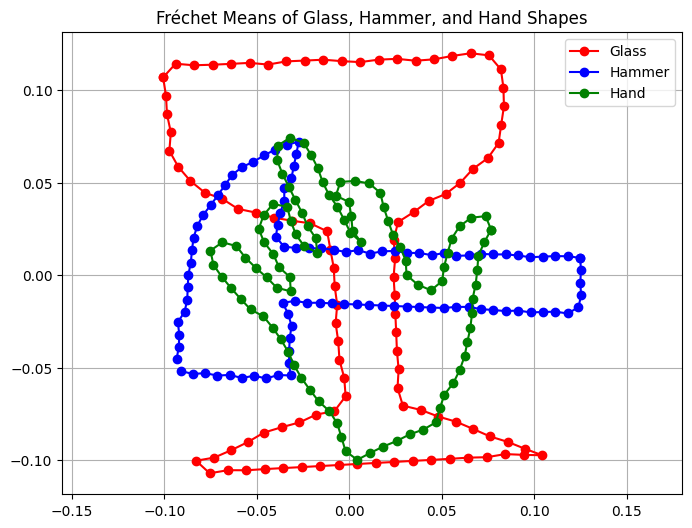

In [ ]:
mean_glass = frechet_mean(glass)
mean_hammer = frechet_mean(hammer)
mean_hand = frechet_mean(hand)

plt.figure(figsize=(8, 6))
plot_shape(mean_glass, label="Glass", col="red")
plot_shape(mean_hammer, label="Hammer", col="blue")
plot_shape(mean_hand, label="Hand", col="green")

plt.title("Fréchet Means of Glass, Hammer, and Hand Shapes")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparisons = [("Glass vs Hammer", glass, hammer),
               ("Glass vs Hand", glass, hand),
               ("Hammer vs Hand", hammer, hand)]

results = []
for name, g1, g2 in comparisons:
  D, n, m = D_kendall_distance(g1, g2)
  D_ts_true = compute_energy(D, n, m)
  _, p = two_sample_test(g1, g2, 100000)
  results.append({
      "Comparison": name,
      "Energy Statistic": D_ts_true,
      "Permutation p-value": p,
      "Significant": "Yes" if p < 0.05 else "No"
  })

results_df = pd.DataFrame(results)
results_df

Euclidean p-value: 0.00031
Kendall p-value: 0.0
Euclidean p-value: 2e-05
Kendall p-value: 7e-05
Euclidean p-value: 0.00085
Kendall p-value: 0.00988


,Comparison,Energy Statistic,Permutation p-value,Significant
0,Glass vs Hammer,4.534990,0.00000,Yes
1,Glass vs Hand,1.553576,0.00007,Yes
2,Hammer vs Hand,1.101210,0.00988,Yes


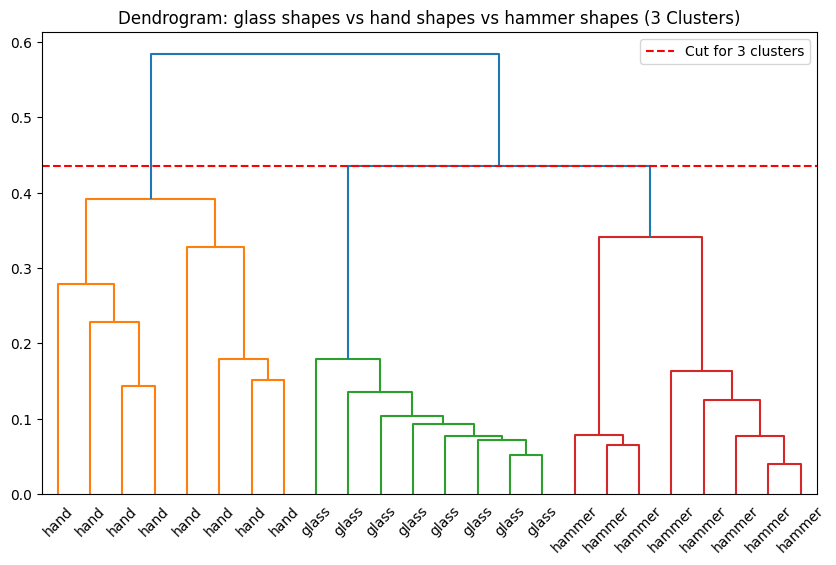

Cluster,1,2,3
Shape,,,
glass,0,8,0
hammer,0,0,8
hand,8,0,0


In [ ]:
D_kendall_toy, _, _ = D_kendall_distance(glass, hammer + hand)
k_clusters = 3

labels = (
    ['glass'] * len(glass) +
    ['hammer'] * len(hammer) +
    ['hand'] * len(hand)
)

Z = linkage(squareform(D_kendall_toy), method='average')
cluster_ids = fcluster(Z, k_clusters, criterion='maxclust')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=labels, color_threshold=Z[-(k_clusters - 1), 2])
plt.axhline(y=Z[-(k_clusters - 1), 2], color='red', linestyle='--', label=f'Cut for {k_clusters} clusters')
plt.legend()
plt.title(f"Dendrogram: glass shapes vs hand shapes vs hammer shapes ({k_clusters} Clusters)")
plt.show()


cluster_summary_user = pd.DataFrame({
    "Shape": labels,
    "Cluster": cluster_ids
})
cluster_result_user = pd.crosstab(cluster_summary_user["Shape"], cluster_summary_user["Cluster"])
cluster_result_user

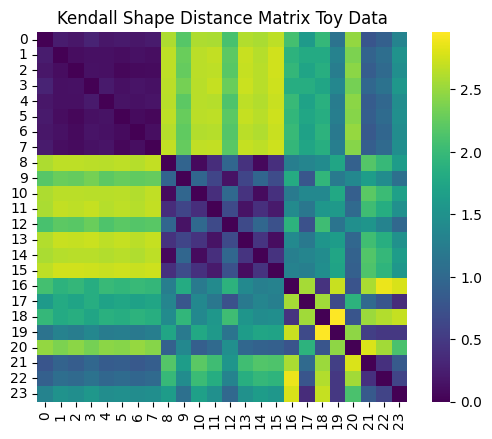

In [ ]:
sns.heatmap(D_kendall_toy, cmap="viridis", square=True)
plt.title("Kendall Shape Distance Matrix Toy Data")
plt.show()

## ADNI Mean Analysis

In [ ]:
seed = 52

mean_control_M = frechet_mean(control_M)
mean_control_F = frechet_mean(control_F)
mean_alzheimers_M = frechet_mean(alzheimers_M)
mean_alzheimers_F = frechet_mean(alzheimers_F)

mean_control = frechet_mean(control_M + control_F)
mean_alzheimers = frechet_mean(alzheimers_M + alzheimers_F)

19 converged
17 converged
14 converged
13 converged
19 converged
16 converged


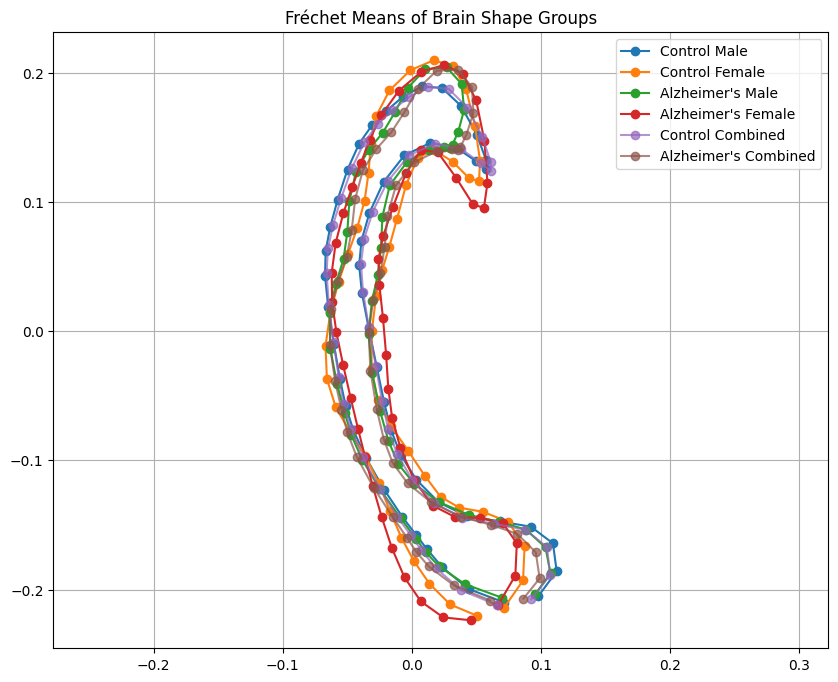

In [ ]:
plt.figure(figsize=(10, 8))

plot_shape(mean_control_M, label="Control Male", alpha=1.0)
plot_shape(mean_control_F, label="Control Female", alpha=1.0)
plot_shape(mean_alzheimers_M, label="Alzheimer's Male", alpha=1.0)
plot_shape(mean_alzheimers_F, label="Alzheimer's Female", alpha=1.0)
plot_shape(mean_control, label="Control Combined", alpha=0.7)
plot_shape(mean_alzheimers, label="Alzheimer's Combined", alpha=0.7)

plt.title("Fréchet Means of Brain Shape Groups")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

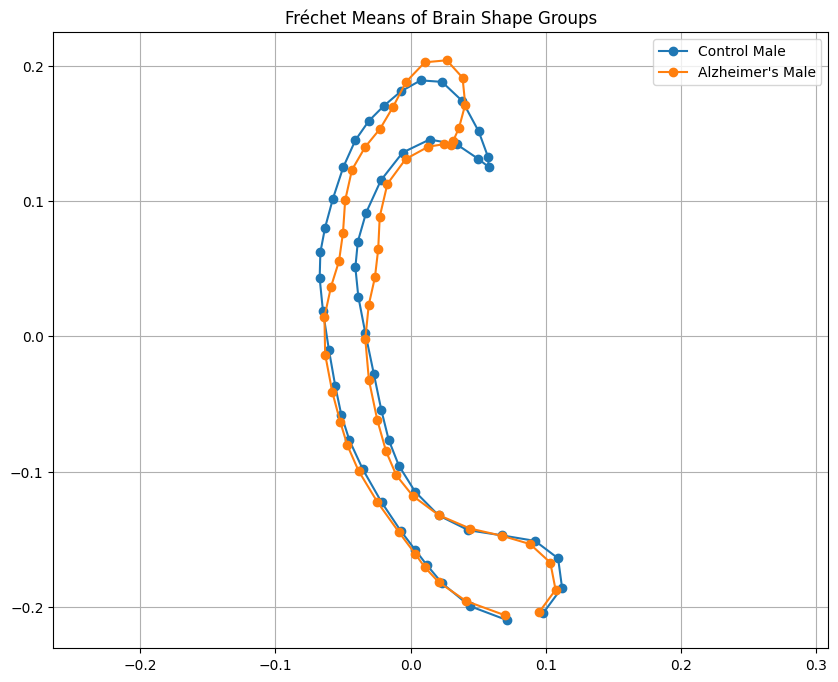

In [ ]:
plt.figure(figsize=(10, 8))

plot_shape(mean_control_M, label="Control Male", alpha=1.0)
plot_shape(mean_alzheimers_M, label="Alzheimer's Male", alpha=1.0)

plt.title("Fréchet Means of Brain Shape Groups")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

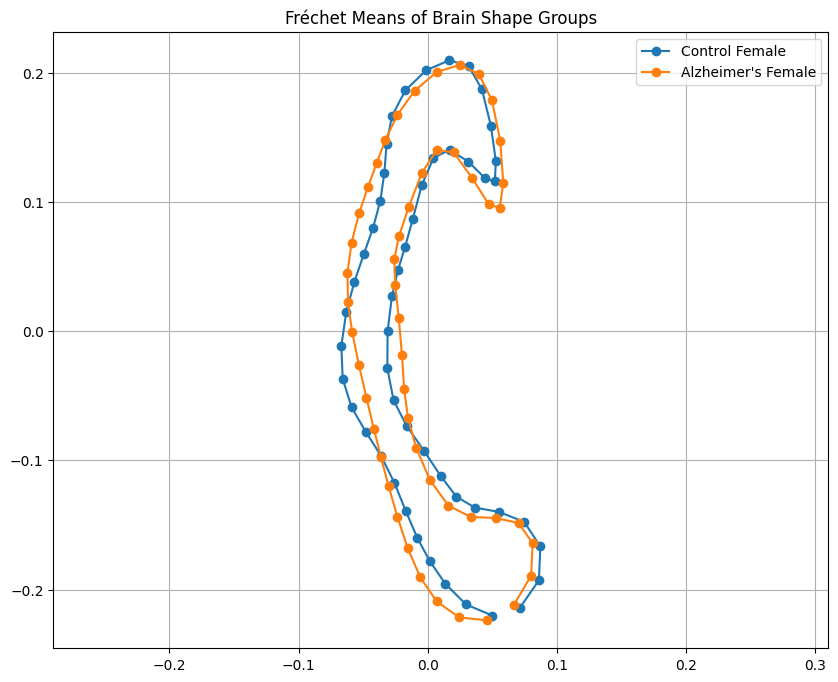

In [ ]:
plt.figure(figsize=(10, 8))

plot_shape(mean_control_F, label="Control Female", alpha=1.0)
plot_shape(mean_alzheimers_F, label="Alzheimer's Female", alpha=1.0)

plt.title("Fréchet Means of Brain Shape Groups")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

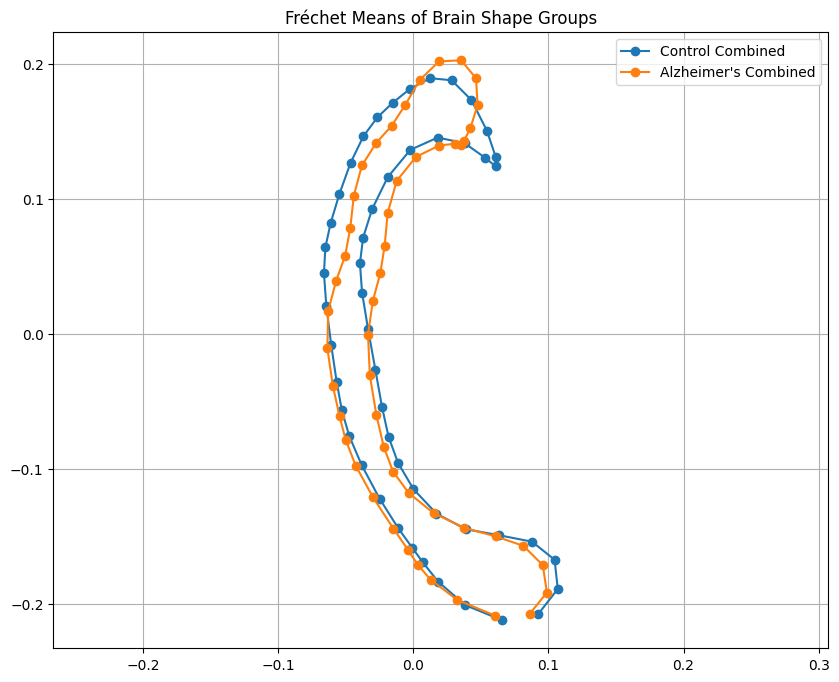

In [ ]:
plt.figure(figsize=(10, 8))


plot_shape(mean_control, label="Control Combined")
plot_shape(mean_alzheimers, label="Alzheimer's Combined")

plt.title("Fréchet Means of Brain Shape Groups")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

## ADNI Permutation Tests

In [ ]:
comparisons = [
    ("Male Control vs. Male Alzheimer’s", control_M, alzheimers_M),
    ("Female Control vs. Female Alzheimer’s", control_F, alzheimers_F),
    ("Combined Control vs. Combined Alzheimer’s", control_M + control_F, alzheimers_M + alzheimers_F)
]

results = []
for name, g1, g2 in comparisons:
  D, n, m = D_kendall_distance(g1, g2)
  D_ts_true = compute_energy(D, n, m)
  _, p = two_sample_test(g1, g2, num_iter = 1000)

  results.append({
      "Comparison": name,
      "Energy Statistic": D_ts_true,
      "Permutation p-value": p,
      "Significant": "Yes" if p < 0.05 else "No"
  })

results_df = pd.DataFrame(results)
results_df

Euclidean p-value: 0.486
Kendall p-value: 0.007
Euclidean p-value: 0.529
Kendall p-value: 0.027
Euclidean p-value: 0.239
Kendall p-value: 0.0


,Comparison,Energy Statistic,Permutation p-value,Significant
0,Male Control vs. Male Alzheimer’s,0.004301,0.007,Yes
1,Female Control vs. Female Alzheimer’s,0.003457,0.027,Yes
2,Combined Control vs. Combined Alzheimer’s,0.003298,0.000,Yes


## ADNI Clustering

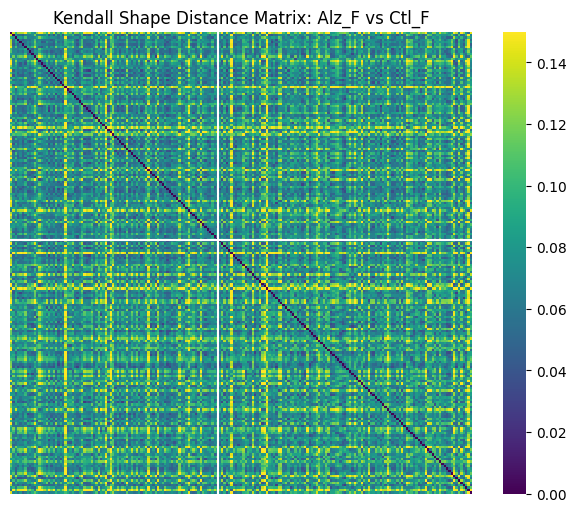

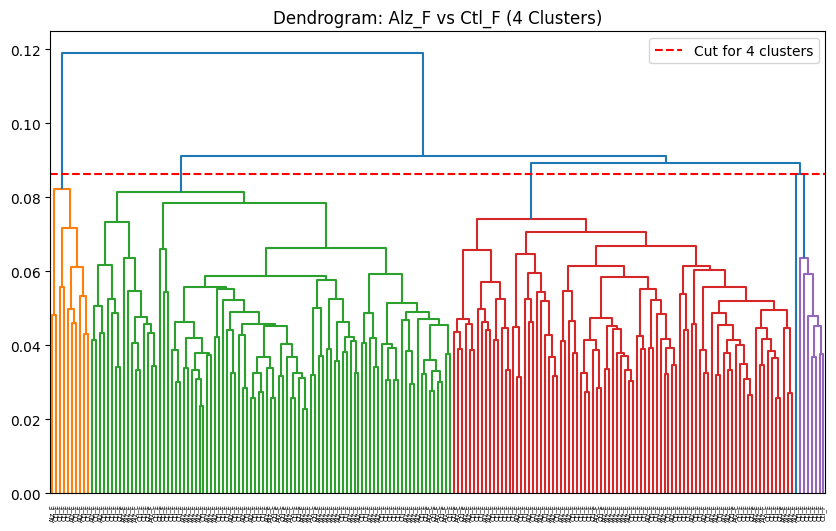

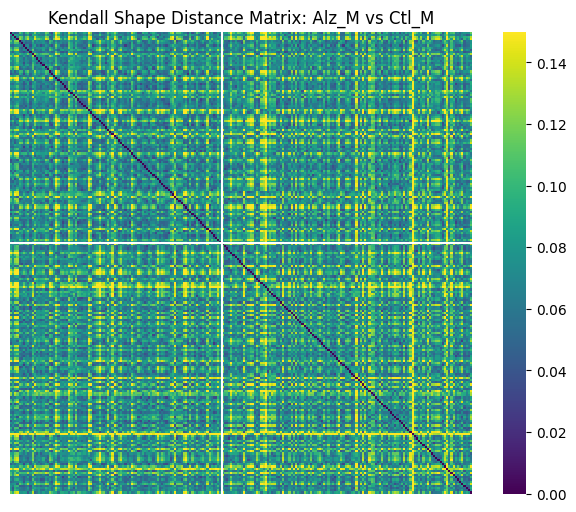

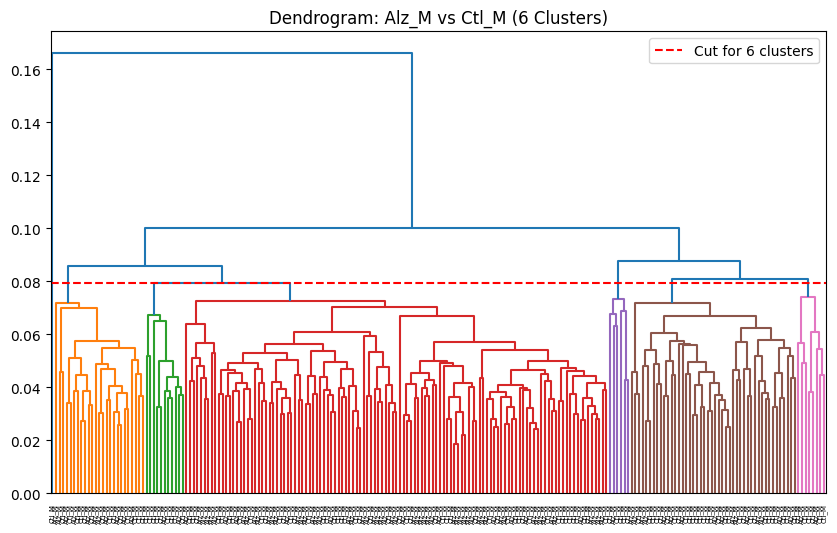

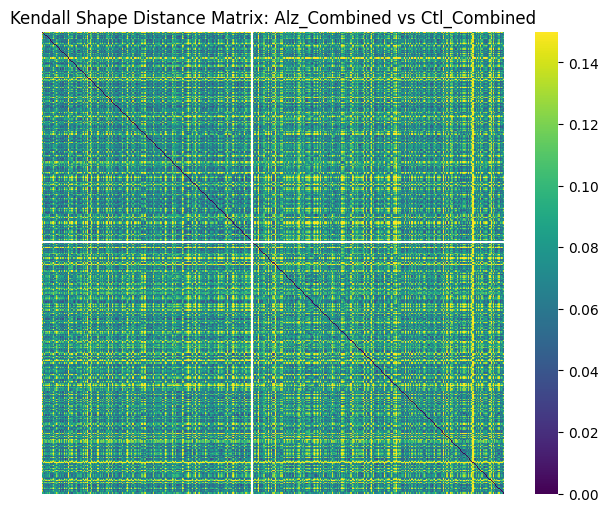

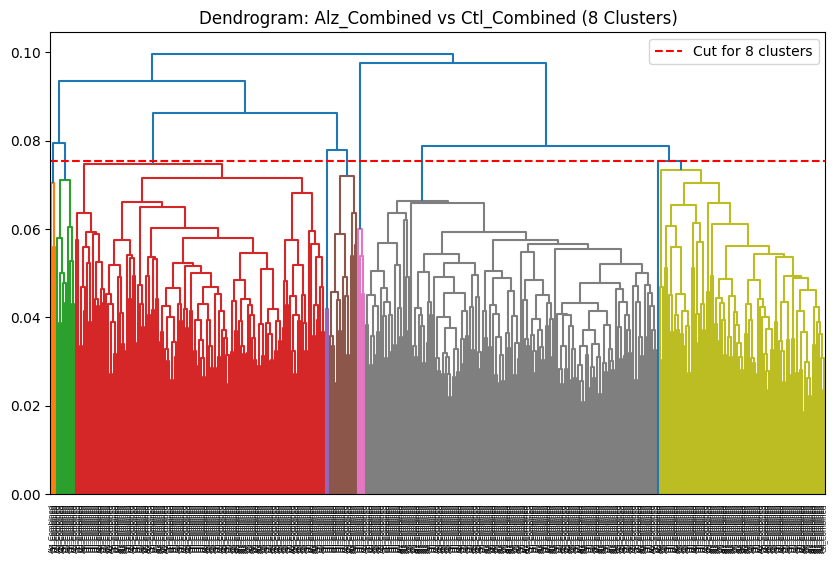

In [ ]:
results1 = cluster_and_plot_shapes(alzheimers_F, control_F, k_clusters=4, group1_label="Alz_F", group2_label="Ctl_F")
results2 = cluster_and_plot_shapes(alzheimers_M, control_M, k_clusters=6, group1_label="Alz_M", group2_label="Ctl_M")
results3 = cluster_and_plot_shapes(alzheimers_F + alzheimers_M, control_F + control_M, k_clusters=8, group1_label="Alz_Combined", group2_label="Ctl_Combined")


In [ ]:
results1

Cluster,1,2,3,4
Group,,,,
Alz_F,3,45,39,1
Ctl_F,7,46,47,7


In [ ]:
results2

Cluster,1,2,3,4,5,6
Group,,,,,,
Alz_M,11,68,1,16,2,0
Ctl_M,14,60,5,30,6,1


In [ ]:
results3

Cluster,1,2,3,4,5,6,7,8
Group,,,,,,,,
Alz_Combined,1,3,54,0,4,0,78,46
Ctl_Combined,2,7,78,2,11,4,76,43
